In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from DataTransformation import LowPassFilter, PrincipalComponentAnalysis
from TemporalAbstraction import NumericalAbstraction
from FrequencyAbstraction import FourierTransformation
from sklearn.cluster import KMeans

mpl.style.use("fivethirtyeight")
mpl.rcParams["figure.figsize"] = (15, 8)
mpl.rcParams["figure.dpi"] = 50
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25

In [2]:
# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------

df = pd.read_pickle("../data/interim/02_outliers_removes_chauvenet.pkl")
predictor_columns = df.columns[:6].tolist()

# Columns used to generate the new features
predictor_columns 


['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']

In [3]:
# --------------------------------------------------------------
# Dealing with missing values (imputation)
# --------------------------------------------------------------

# Concate the percentage of missing values per column with the number
# of missing values per column in a dataframe
def calculate_missing_values(df):
    """
    Calculate the percentage and total count of missing values for each column in the DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: DataFrame with columns "Percentage of missing values (%)" and "Total of missing values",
                      containing information about missing values for each column.
    """
    missing_values_percentage = df.isnull().sum() / len(df) * 100
    total_missing_values = df.isnull().sum()

    df_missing_values = pd.concat(
        [missing_values_percentage, total_missing_values],
        axis=1,
        keys=["Percentage of missing values (%)", "Total of missing values"],
    ).sort_values(by="Percentage of missing values (%)", ascending=False)

    return df_missing_values


calculate_missing_values(df)


,Percentage of missing values (%),Total of missing values
gyr_y,0.782396,64
gyr_z,0.757946,62
gyr_x,0.305623,25
acc_y,0.146699,12
acc_z,0.122249,10
acc_x,0.085575,7
participant,0.000000,0
label,0.000000,0
category,0.000000,0
set,0.000000,0


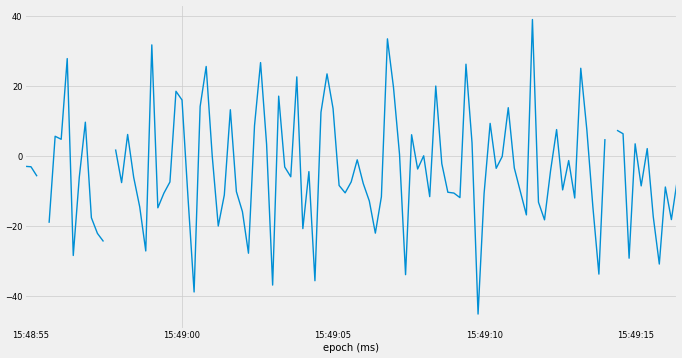

In [4]:
# Add a subset at random and plot it to verify missing values
set = 33
sensor = "gyr_y"
subset = df[df["set"] == set][sensor]
subset.plot();

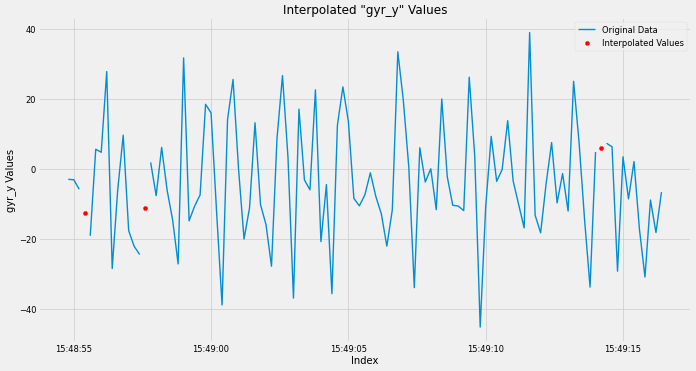

In [5]:

# Interpolate linearly the NaN values
subset_interpolated = subset.interpolate()
# Find the indices of the interpolated values
interpolated_indices = subset_interpolated[
    subset_interpolated.notnull() & subset.isnull()
].index
# Plot the "gyr_y" values
plt.plot(subset.index, subset.values, label="Original Data")
# Plot the interpolated values as a scatter point
plt.scatter(
    interpolated_indices,
    subset_interpolated[interpolated_indices],
    color="red",
    label="Interpolated Values",
    marker="o",
)
plt.xlabel("Index")
plt.ylabel("gyr_y Values")
plt.title('Interpolated "gyr_y" Values')
plt.legend()
plt.show()


In [6]:

# Loop through all the columns and interpolate the NaN values
for col in predictor_columns:
    df[col] = df[col].interpolate()

calculate_missing_values(df)



,Percentage of missing values (%),Total of missing values
acc_x,0.0,0
acc_y,0.0,0
acc_z,0.0,0
gyr_x,0.0,0
gyr_y,0.0,0
gyr_z,0.0,0
participant,0.0,0
label,0.0,0
category,0.0,0
set,0.0,0


<Axes: xlabel='epoch (ms)'>

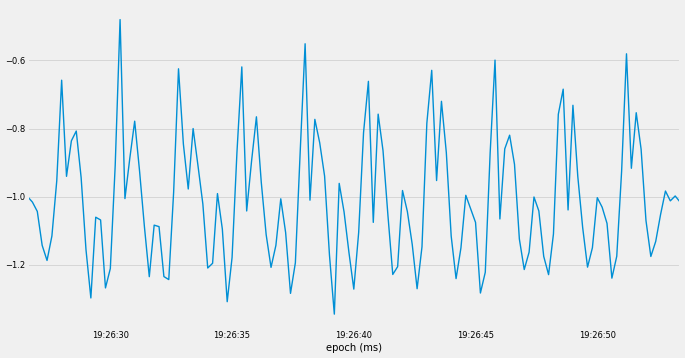

In [7]:
# --------------------------------------------------------------
# Calculating set duration
# --------------------------------------------------------------

# Add a subset at random and plot it (medium, 10 reps)
set = 7
sensor = "acc_y"
subset = df[df["set"] == set][sensor]
subset.plot()


<Axes: xlabel='epoch (ms)'>

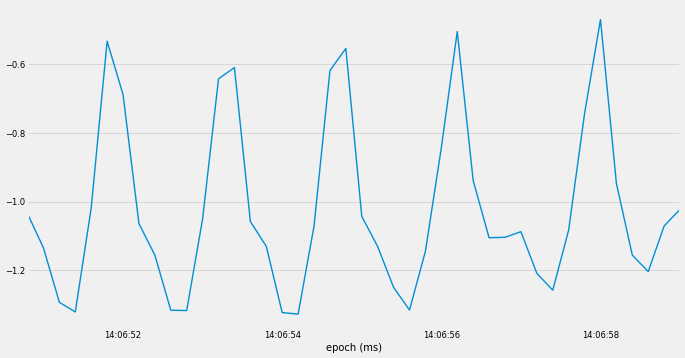

In [8]:
# Add a subset at random and plot it (heavy, 5 reps)
set = 21
sensor = "acc_y"
subset = df[df["set"] == set][sensor]
subset.plot()


In [9]:

# Time difference between the first and last value of the set 1
duration = df[df["set"] == 1].index[-1] - df[df["set"] == 1].index[0]
duration.seconds


16

In [10]:

# Loop through all the columns and calculate the set duration
for s in df["set"].unique():
    start = df[df["set"] == s].index[0]
    stop = df[df["set"] == s].index[-1]
    duration = stop - start
    df.loc[(df["set"] == s), "duration"] = duration.seconds

# Duration  for eac repetition
df.groupby("category")["duration"].describe()



,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
heavy,3286.0,15.090383,3.057947,8.0,14.0,15.0,17.0,20.0
medium,4154.0,25.372412,5.316038,13.0,21.0,26.0,30.0,35.0
sitting,340.0,33.000000,0.000000,33.0,33.0,33.0,33.0,33.0
standing,400.0,39.000000,0.000000,39.0,39.0,39.0,39.0,39.0


In [11]:
duration_df = df.groupby("category")["duration"].mean()
print(f'Duration for a single heavy repetition (5 reps): {duration_df.iloc[0] / 5}')
print(f'Duration for a single medium repetition (10 reps): {duration_df.iloc[1] / 10}')


Duration for a single heavy repetition (5 reps): 3.018076688983567
Duration for a single medium repetition (10 reps): 2.5372412132883966


#### **Butterworth low-pass filter**

- A Butterworth low-pass filter is a type of filter used to remove high-frequency noise from a dataset.
- High-frequency noise refers to any undesired or random fluctuations in the data that occur at high frequencies.
- The filter is designed to eliminate this noise, allowing only the low-frequency components of the data to pass through.
- The filter achieves this by attenuating or reducing the amplitude of the high-frequency components, leaving the low-frequency components unchanged.
- The filter can be applied to various types of data, such as time series data, audio signals, or images.
- By removing high-frequency noise from the data, the filter helps improve the accuracy of machine learning models.
- By preserving the underlying pattern of the data, the filter helps mitigate the effect of noise on the model, which can lead to better results.

<img src="../img/butter_filter.jpg">

*Source: Hoogendoorn, M., & Funk, B. (2018). Machine learning for the quantified self. On the art of learning from sensory data.*



In [12]:
# --------------------------------------------------------------
# Butterworth lowpass filter
# --------------------------------------------------------------

df_lowpass = df.copy()
LowPass = LowPassFilter()

# Defining sampling frequency (sample rate)
fs = 1000 / 200  # Samples per second (1000ms/20ms)
cutoff = 1  # Cutoff frequency of the filter (in Hz)

# Add low pass a single sensor
df_lowpass = LowPass.low_pass_filter(df_lowpass, "acc_y", fs, cutoff, order=5)

df_lowpass.head()

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,acc_y_lowpass
epoch (ms),,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,28,16.0,0.977022
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,28,16.0,0.962269
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,28,16.0,0.966368
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,28,16.0,0.979343
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,28,16.0,0.966609


dead


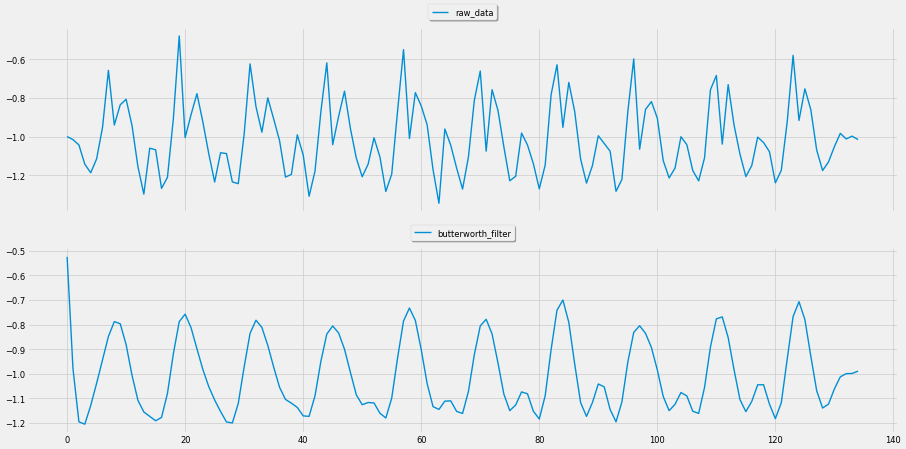

In [13]:
# Comparing with the filter data
set = 7
sensor = "acc_y"

subset = df_lowpass[df_lowpass["set"] == set]
print(subset["label"][0])

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
ax[0].plot(subset[sensor].reset_index(drop=True), label="raw_data")
ax[1].plot(
    subset[sensor + "_lowpass"].reset_index(drop=True), label="butterworth_filter"
)
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
plt.show()

In [14]:
# --------------------------------------------------------------
# Turn into a single function (plot_binary_outliers)
# --------------------------------------------------------------

def apply_and_plot_low_pass_filter(df, set_value, sensor_column, fs, cutoff, order=5):
    """
    Apply a low-pass filter to the specified sensor column in the DataFrame for a given dataset.
    Plot the raw data and the filtered data side by side.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        set_value (int): The dataset value to filter and plot.
        sensor_column (str): Name of the column (sensor) to apply the filter to and plot.
        fs (float): Sampling frequency (in Hz).
        cutoff (float): Cutoff frequency of the filter (in Hz).
        order (int, optional): Order of the filter. Defaults to 5.
    """
    df_lowpass = df.copy()
    LowPass = LowPassFilter()

    # Apply the low-pass filter
    df_lowpass = LowPass.low_pass_filter(
        df_lowpass, sensor_column, fs, cutoff, order=order
    )

    # Filter the subset of data for the specified set_value and sensor_column
    subset = df_lowpass[df_lowpass["set"] == set_value]

    # Print the label of the first row in the subset
    category = subset["label"].iloc[0]

    # Plot the raw data and the filtered data
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
    ax[0].plot(subset[sensor_column].reset_index(drop=True), label="raw_data")
    ax[1].plot(
        subset[sensor_column + "_lowpass"].reset_index(drop=True),
        label="butterworth_filter",
    )
    ax[0].legend(
        loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True
    )
    ax[1].legend(
        loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True
    )

    plt.suptitle(
        f"Comparison of Raw and Butterworth-Filtered Data for Set: {set_value}, category: {category} and Sensor: {sensor_column}",
        fontsize=16,
    )

    plt.show()

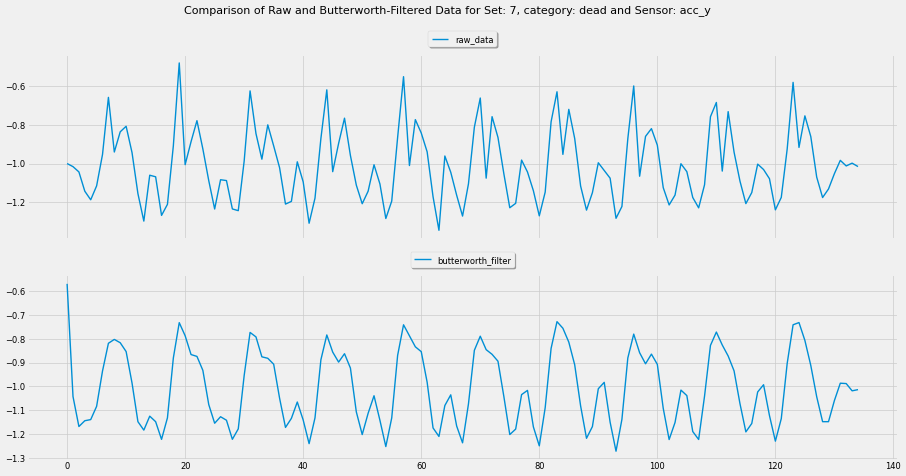

In [15]:
# Example usage:
# Assuming you have a DataFrame named "df" containing your data
# You can call the function like this:
fs = 1000 / 200
cutoff = 1.2
set_value = 7
sensor_column = "acc_y"

apply_and_plot_low_pass_filter(df, set_value, sensor_column, fs, cutoff, order=5)

In [16]:
# Loop through all the columns and apply the low-pass filter
for col in predictor_columns:
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, fs, cutoff, order=5)
    df_lowpass[col] = df_lowpass[col + "_lowpass"]
    del df_lowpass[col + "_lowpass"]

df_lowpass.columns

Index(['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'participant',
       'label', 'category', 'set', 'duration'],
      dtype='object')

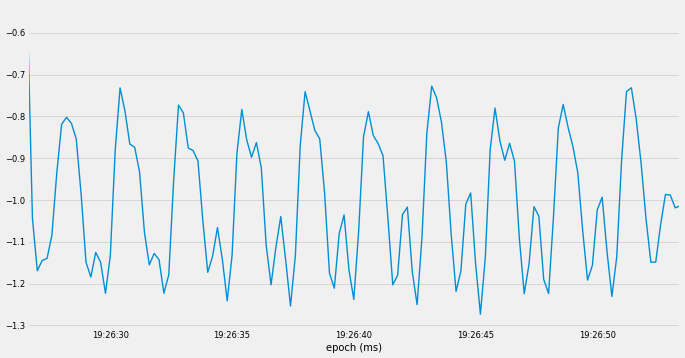

In [17]:
# Add a subset at random after the lowpass filter
set = 7
sensor = "acc_y"
subset = df_lowpass[df_lowpass["set"] == set][sensor]
subset.plot();

#### Principal component analysis (PCA)
- PCA stands for Principal Component Analysis, which is a technique used in machine learning to reduce the complexity of data.
- The technique involves transforming the original dataset into a new set of variables called principal components.
- The transformation is done in a way that the new set of variables captures the most information from the original dataset.
- The principal components are chosen to explain the maximum amount of variance in the original dataset.
- By reducing the number of necessary variables, PCA helps to simplify the data and facilitates analysis and predictions.
- The principal components are orthogonal to each other, meaning they are uncorrelated and independent.
- PCA is particularly useful when dealing with high-dimensional datasets, where the number of variables is large.
- PCA can also be used for data visualization, where the principal components can be plotted against each other to visualize the data in a lower-dimensional space.
- PCA is a widely used technique in machine learning and is often employed as a preprocessing step before applying other machine learning algorithms.

<img src="../img/pca.jpg">

*An example of principal component analysis (PCA) for a two-dimensional data set*

In [18]:
# --------------------------------------------------------------
# Principal component analysis PCA
# --------------------------------------------------------------

df_pca = df_lowpass.copy()

pca = PrincipalComponentAnalysis()

# Get the variance of each feature
pca_values = pca.determine_pc_explained_variance(df_pca, predictor_columns)
pca_values

array([0.55890974, 0.28004761, 0.08136852, 0.05385174, 0.01563767,
       0.01018473])

#### Elbow technique

- The elbow technique is a method used in Principal Component Analysis (PCA) to determine the optimal number of components to use.
- PCA is a statistical technique used to reduce the dimensionality of a dataset by identifying patterns and relationships among variables.
- The elbow technique works by testing various different numbers of components and evaluating the variance captured by each number of components.
- Variance is a measure of the spread of a dataset. In PCA, it represents the amount of information captured by each component.
- The optimal number of components is chosen as the number of components that capture the most variation while also not incorporating too many components.
- Incorporating too many components can lead to overfitting, where the model is overly complex and may not generalize well to new data.
- To determine the optimal number of components, the captured variance is graphically plotted against the number of components.
- The graph typically shows a decreasing trend in captured variance as the number of components increases.
- The "elbow" point on the graph is the point where the rate of change in variance decreases, indicating that adding more components doesn't significantly improve the analysis.
- The elbow point is usually chosen as the optimal number of components as it balances capturing sufficient variation with not incorporating too many components.

<img src="../img/elbow_method.jpg">

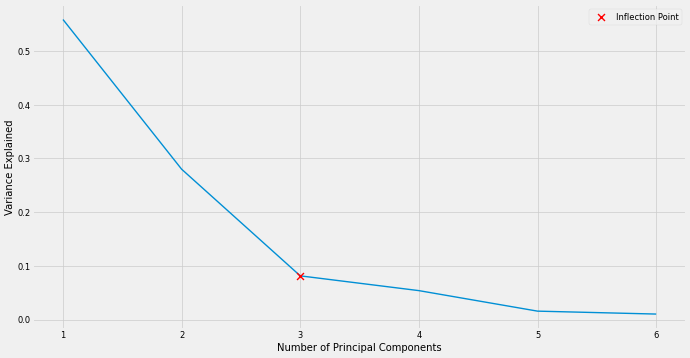

In [19]:
# Determine the number of principal components using elbow technique
# Calculate the second derivative of the variance explained
second_derivative = np.diff(pca_values, n=2)

# Find the index of the inflection point (where the second derivative changes sign)
inflection_index = np.where(second_derivative < 0)[0][0]

# Plot the PCA values
plt.figure(figsize=(15, 8))
plt.plot(range(1, len(pca_values) + 1), pca_values)

# Plot a mark at the point of inflection
plt.scatter(
    inflection_index + 1,  # add 1 cause the index is 0 based
    pca_values[inflection_index],
    color="red",
    label="Inflection Point",
    marker="x",
    s=100,
    zorder=10,
)

plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.legend()
plt.show()

In [20]:
# Summarazing all features into 3 principal components
# Apply a PCA given the number of components we have selected.
# We add new pca columns.
df_pca = pca.apply_pca(df_pca, predictor_columns, 3)
df_pca.head()


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3
epoch (ms),,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,28,16.0,-0.285207,-0.075177,-0.008812
2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,28,16.0,-0.283237,-0.074468,0.017794
2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,28,16.0,-0.282435,-0.080983,0.029803
2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,28,16.0,-0.284541,-0.089316,0.015012
2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,28,16.0,-0.284981,-0.094628,0.010815


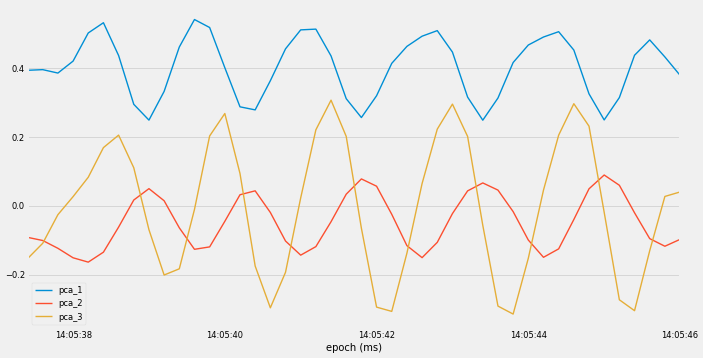

In [21]:
# Visualize the PCA components
set = 45
subset = df_pca[df_pca["set"] == set]
subset[["pca_1", "pca_2", "pca_3"]].plot();

#### Square Root of the Sum of the Squares

- The scalar magnitude r is calculated by combining the x, y, and z measurements into a single value. This is done by taking the square root of the sum of the squares of each measurement.
- The advantage of using r instead of the individual x, y, and z measurements is that it is "orientation-neutral." This means that no matter how the device is oriented (upside down, sideways, etc.), the value of r will still be meaningful.
- Additionally, r can "handle dynamic reorientations," which means that if the device is moved or rotated during the measurement period, the value of r will still accurately represent the overall motion and rotation.
- Overall, calculating the scalar magnitude r is a useful way to extract meaningful features from accelerometer and gyroscope data that can be used for machine learning models.

$$
r_{magnitude} = \sqrt{x^2 + y^2 + z^2}
$$

In [22]:
# --------------------------------------------------------------
# Sum of squares attributes
# --------------------------------------------------------------

df_squared = df_pca.copy()

# Square all
acc_r = df_squared["acc_x"] ** 2 + df_squared["acc_y"] ** 2 + df_squared["acc_z"] ** 2
gyr_r = df_squared["gyr_x"] ** 2 + df_squared["gyr_y"] ** 2 + df_squared["gyr_z"] ** 2

df_squared["acc_r"] = np.sqrt(acc_r)
df_squared["gyr_r"] = np.sqrt(gyr_r)

df_squared.head()

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3,acc_r,gyr_r
epoch (ms),,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,28,16.0,-0.285207,-0.075177,-0.008812,0.979670,3.229288
2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,28,16.0,-0.283237,-0.074468,0.017794,0.972630,2.524460
2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,28,16.0,-0.282435,-0.080983,0.029803,0.966432,4.741409
2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,28,16.0,-0.284541,-0.089316,0.015012,0.969338,4.269510
2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,28,16.0,-0.284981,-0.094628,0.010815,0.971528,2.772009


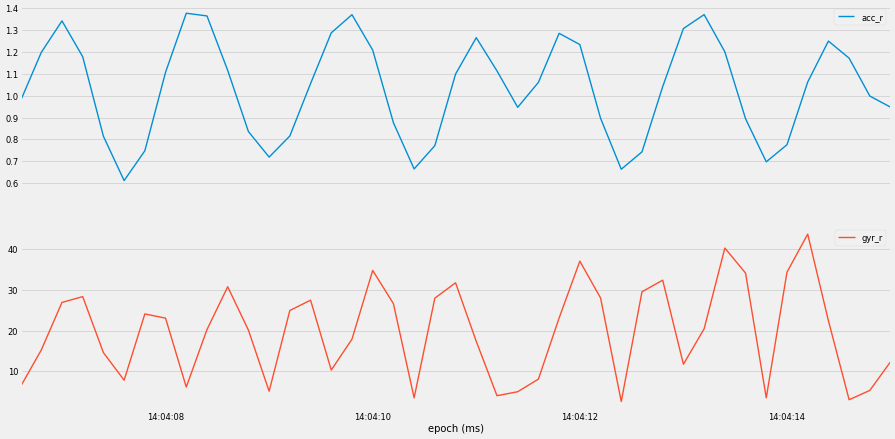

In [23]:
# Visuzalizing the squared attributes
set = 20
subset = df_squared[df_squared["set"] == set]
subset[["acc_r", "gyr_r"]].plot(subplots=True, figsize=(20, 10));


In [24]:
# Add the new cols
predictor_columns = predictor_columns + ["acc_r", "gyr_r"]

#### Temporal Abstraction

- The technique involves creating a continuous subset of the complete data and calculating metrics within that subset.
- By doing so, it can help reduce the impact of random data fluctuations, making it easier to identify underlying trends.
- The size of the subset can be adjusted to meet the needs of the analysis.
- A smaller subset will provide a more responsive continuous metrics, while a larger subset will yield smoother metrics with less sensitivity to short-term fluctuations.
- Overall, it can be a useful tool for gaining insights into trends within a dataset, particularly when dealing with data that exhibits a high degree of volatility.


<img src="../img/rolling_window.jpg">


In [25]:
# --------------------------------------------------------------
# Temporal abstraction
# --------------------------------------------------------------

df_temporal = df_squared.copy()

NumAbs = NumericalAbstraction()

# Window size for the rooling in 1s (abstraction)
ws = int(1000 / 200)  # Delta is 200ms

# Add new features, mean and std for all predictor columns
# We need to separate the data by set before applying the aggragation
df_temporal_list = []
for s in df_temporal["set"].unique():
    subset = df_temporal[df_temporal["set"] == s].copy()
    for col in predictor_columns:
        subset = NumAbs.abstract_numerical(subset, [col], ws, "mean")
        subset = NumAbs.abstract_numerical(subset, [col], ws, "std")
    df_temporal_list.append(subset)

df_temporal = pd.concat(df_temporal_list)
df_temporal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8180 entries, 2019-01-11 15:08:05.200000 to 2019-01-19 17:35:13.600000
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   acc_x                 8180 non-null   float64
 1   acc_y                 8180 non-null   float64
 2   acc_z                 8180 non-null   float64
 3   gyr_x                 8180 non-null   float64
 4   gyr_y                 8180 non-null   float64
 5   gyr_z                 8180 non-null   float64
 6   participant           8180 non-null   object 
 7   label                 8180 non-null   object 
 8   category              8180 non-null   object 
 9   set                   8180 non-null   int32  
 10  duration              8180 non-null   float64
 11  pca_1                 8180 non-null   float64
 12  pca_2                 8180 non-null   float64
 13  pca_3                 8180 non-null   float64
 14  acc_r                 

In [26]:
# Missing values generated by new features
calculate_missing_values(df_temporal)


,Percentage of missing values (%),Total of missing values
acc_x_temp_mean_ws_5,4.00978,328
acc_x_temp_std_ws_5,4.00978,328
gyr_r_temp_mean_ws_5,4.00978,328
acc_r_temp_std_ws_5,4.00978,328
acc_r_temp_mean_ws_5,4.00978,328
gyr_z_temp_std_ws_5,4.00978,328
gyr_z_temp_mean_ws_5,4.00978,328
gyr_y_temp_std_ws_5,4.00978,328
gyr_y_temp_mean_ws_5,4.00978,328
gyr_x_temp_std_ws_5,4.00978,328


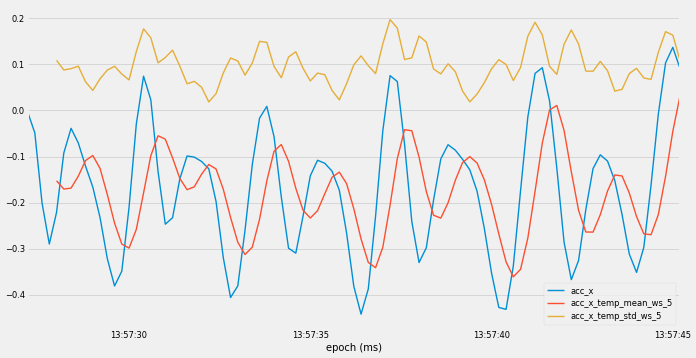

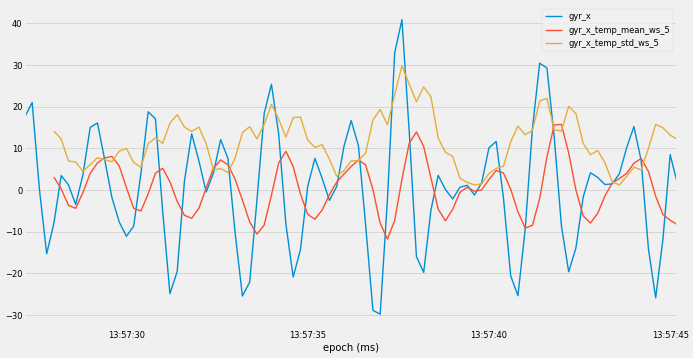

In [27]:
# Visualize the temporal abstraction
set = 44

df_temporal[df_temporal["set"] == set][
    ["acc_x", "acc_x_temp_mean_ws_5", "acc_x_temp_std_ws_5"]
].plot()

df_temporal[df_temporal["set"] == set][
    ["gyr_x", "gyr_x_temp_mean_ws_5", "gyr_x_temp_std_ws_5"]
].plot();


#### Discrete Fourier Transformation (DFT)

- The Fourier Transform is a mathematical technique that can be used to represent any sequence of measurements as a combination of sinusoidal functions with different frequencies.
- This means that any complex dataset can be broken down into simpler components that can be analyzed more efficiently.
- By using the DFT, data can be represented in terms of frequency components, which can provide insights into patterns and trends that might not be visible in the raw data.
- This can be particularly useful for analyzing time series data, where patterns may emerge over time that are not immediately apparent.
- In addition to providing information about the data, the DFT can also be used to reduce noise in the data.
- By filtering out high-frequency noise, the DFT can help create more accurate models that are better able to capture the underlying patterns in the data.
- Overall, the DFT is a powerful tool for feature engineering in machine learning, as it enables more efficient analysis of complex datasets and can help improve the accuracy of models.

<img src="../img/dft.jpg">

Features we will be extracted:
- Amplitude (for each of the relevant frequencies that are part of the time window)
-  Max frequency
- Weighted frequency (average)
- Power spectral entropy


In [28]:
# --------------------------------------------------------------
# Frequency features
# --------------------------------------------------------------

df_freq = df_temporal.copy().reset_index()  # Must be a discrete index not time
FreqAbs = FourierTransformation()

ws = int(2800 / 200)  # Avarage of each repetition (2800ms)/ delta time (200ms)
fs = int(1000 / 200)  # Sampling frequency is (1000ms) / delta time (200ms)


# Get frequencies for a single sensor (acc_y) over a certain window.
df_freq = FreqAbs.abstract_frequency(
    df_freq, cols=["acc_y"], window_size=ws, sampling_rate=fs
)

df_freq.columns

Index(['epoch (ms)', 'acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z',
       'participant', 'label', 'category', 'set', 'duration', 'pca_1', 'pca_2',
       'pca_3', 'acc_r', 'gyr_r', 'acc_x_temp_mean_ws_5',
       'acc_x_temp_std_ws_5', 'acc_y_temp_mean_ws_5', 'acc_y_temp_std_ws_5',
       'acc_z_temp_mean_ws_5', 'acc_z_temp_std_ws_5', 'gyr_x_temp_mean_ws_5',
       'gyr_x_temp_std_ws_5', 'gyr_y_temp_mean_ws_5', 'gyr_y_temp_std_ws_5',
       'gyr_z_temp_mean_ws_5', 'gyr_z_temp_std_ws_5', 'acc_r_temp_mean_ws_5',
       'acc_r_temp_std_ws_5', 'gyr_r_temp_mean_ws_5', 'gyr_r_temp_std_ws_5',
       'acc_y_max_freq', 'acc_y_freq_weighted', 'acc_y_pse',
       'acc_y_freq_0.0_Hz_ws_14', 'acc_y_freq_0.357_Hz_ws_14',
       'acc_y_freq_0.714_Hz_ws_14', 'acc_y_freq_1.071_Hz_ws_14',
       'acc_y_freq_1.429_Hz_ws_14', 'acc_y_freq_1.786_Hz_ws_14',
       'acc_y_freq_2.143_Hz_ws_14', 'acc_y_freq_2.5_Hz_ws_14'],
      dtype='object')

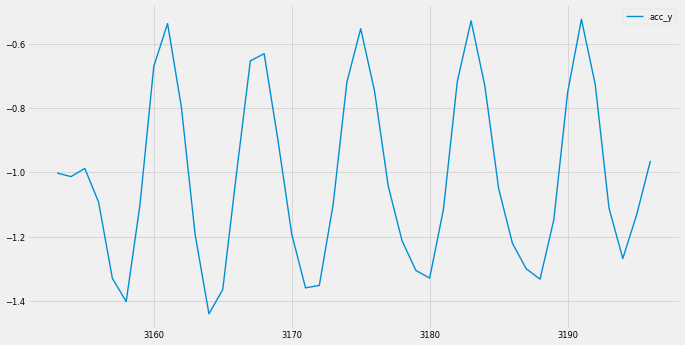

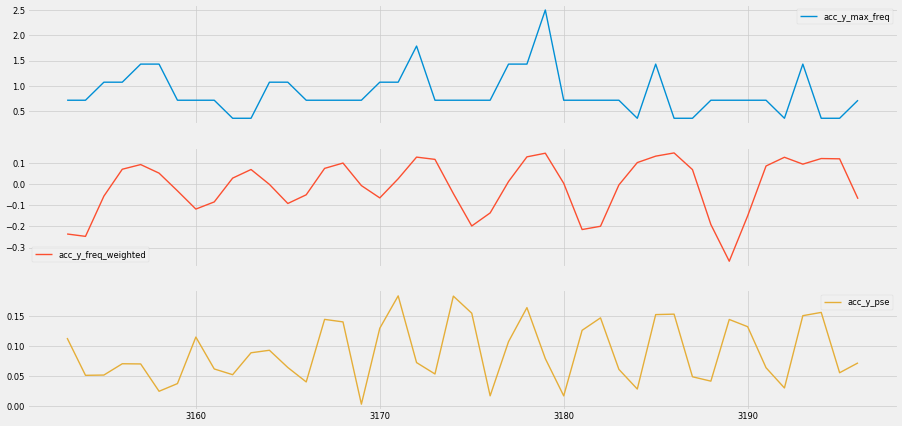

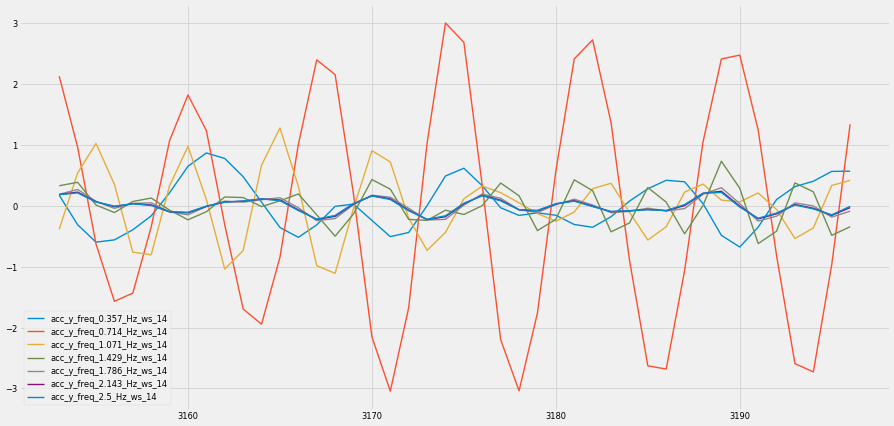

In [29]:
# Visualize plots
set = 45
subset = df_freq[df_freq["set"] == set]

subset[["acc_y"]].plot()

subset[["acc_y_max_freq", "acc_y_freq_weighted", "acc_y_pse"]].plot(
    subplots=True, figsize=(20, 10)
)

subset[
    [
        # "acc_y_freq_0.0_Hz_ws_14",
        "acc_y_freq_0.357_Hz_ws_14",
        "acc_y_freq_0.714_Hz_ws_14",
        "acc_y_freq_1.071_Hz_ws_14",
        "acc_y_freq_1.429_Hz_ws_14",
        "acc_y_freq_1.786_Hz_ws_14",
        "acc_y_freq_2.143_Hz_ws_14",
        "acc_y_freq_2.5_Hz_ws_14",
    ]
].plot(figsize=(20, 10));

In [30]:
# Loop to get the frequency (FRF) for each set individually.
df_freq_list = []
for s in df_freq["set"].unique():
    print(f"Applying FRF for set: {s}")
    subset = df_freq[df_freq["set"] == s].reset_index(drop=True).copy()
    subset = FreqAbs.abstract_frequency(subset, predictor_columns, ws, fs)
    df_freq_list.append(subset)

df_freq = pd.concat(df_freq_list).set_index("epoch (ms)", drop=True)

df_freq.head()

Applying FRF for set: 28
Applying FRF for set: 1
Applying FRF for set: 29
Applying FRF for set: 3
Applying FRF for set: 9
Applying FRF for set: 30
Applying FRF for set: 10
Applying FRF for set: 31
Applying FRF for set: 11
Applying FRF for set: 32
Applying FRF for set: 33
Applying FRF for set: 15
Applying FRF for set: 34
Applying FRF for set: 16
Applying FRF for set: 35
Applying FRF for set: 17
Applying FRF for set: 25
Applying FRF for set: 36
Applying FRF for set: 26
Applying FRF for set: 27
Applying FRF for set: 6
Applying FRF for set: 60
Applying FRF for set: 62
Applying FRF for set: 68
Applying FRF for set: 4
Applying FRF for set: 2
Applying FRF for set: 37
Applying FRF for set: 38
Applying FRF for set: 12
Applying FRF for set: 39
Applying FRF for set: 13
Applying FRF for set: 43
Applying FRF for set: 14
Applying FRF for set: 44
Applying FRF for set: 47
Applying FRF for set: 20
Applying FRF for set: 45
Applying FRF for set: 21
Applying FRF for set: 46
Applying FRF for set: 63
Applyi

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df_freq.tail() 

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-19 17:35:12.800,-0.019458,-1.271116,-0.035906,-15.799361,-1.984103,11.238770,E,row,medium,80,...,0.374111,0.371121,356.999310,37.225052,-30.548345,-24.611281,-30.034455,57.499995,47.676832,13.120656
2019-01-19 17:35:13.000,-0.052603,-1.138248,-0.069417,1.848450,-5.237461,0.032622,E,row,medium,80,...,-0.342863,0.368936,329.376401,-9.495142,-9.566931,-100.584577,11.850592,22.591083,-21.194271,10.423726
2019-01-19 17:35:13.200,-0.048619,-0.983693,-0.040378,2.858435,-3.516559,-1.389640,E,row,medium,80,...,0.089814,0.385491,324.954746,-30.990013,42.409537,-11.296864,55.642104,-50.257342,17.816322,-1.564601
2019-01-19 17:35:13.400,-0.039355,-0.962997,-0.022832,-1.631987,-2.094743,1.087707,E,row,medium,80,...,0.547473,0.679167,303.259448,-62.524415,56.226636,91.320171,-16.793528,42.935563,14.340376,18.279954
2019-01-19 17:35:13.600,-0.044037,-1.028640,-0.043956,-0.607820,-4.511593,1.096251,E,row,medium,80,...,0.567756,0.800697,268.553337,-93.258089,31.308766,78.706354,-26.808227,46.370132,8.753593,21.446611


In [32]:
# --------------------------------------------------------------
# Dealing with overlapping windows
# --------------------------------------------------------------
print(f'Shape before: {df_freq.shape}')

calculate_missing_values(df_freq)  # Missing values before
df_freq = df_freq.dropna()
calculate_missing_values(df_freq)  # missing values after

# Deleting part of the data (jumping a line)
# Reducing correlation between records to avoid overfitting
# This will cause a 50% loss in dataframe
df_freq = df_freq.iloc[::2]

print(f'Shape after: {df_freq.shape}')

Shape before: (8180, 120)
Shape after: (3516, 120)


#### K-means Clustering

- K-means clustering is a type of machine learning algorithm used to group data into clusters based on their similarity.
- It is an unsupervised learning algorithm, meaning it doesn't require any labeled data to train the model.
- The algorithm randomly initializes k points, also known as centroids, in the data space.
- The value of k is determined by the user and represents the number of clusters the algorithm will create.
- The algorithm then calculates the distance between each data point and each centroid.
- The distance is typically calculated using the formula for Euclidean distance, which measures the straight-line distance between two points in a multidimensional space.
- The algorithm assigns each data point to the nearest centroid based on the calculated distance.
- This process is repeated until the centroids no longer move or until a maximum number of iterations is reached.
- K-means clustering is a popular feature engineering technique used in many applications, such as identifying the most important features in a dataset, segmenting customers into different clusters based on their buying behaviors, anomaly detection, and image compression.
- The Elbow Method is a technique used to determine the optimal number of clusters for a given dataset.
- It graphically represents the inertia, which is the sum of squared distances of samples to the nearest cluster center, for each k (number of clusters) against k.


<img src="../img/km.jpg">

Text(0, 0.5, 'Sum of squared distances')

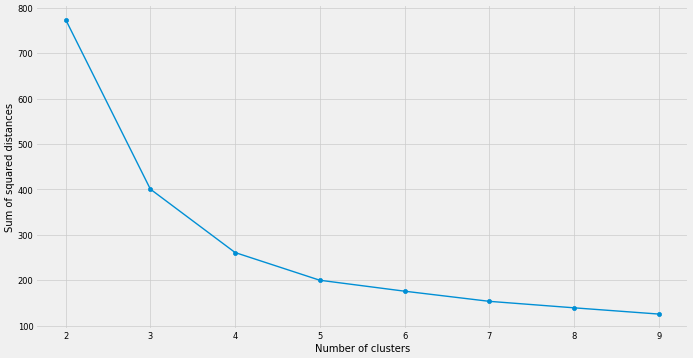

In [34]:
# --------------------------------------------------------------
# Clustering
# --------------------------------------------------------------

df_cluster = df_freq.copy()

cluster_columns = ["acc_x", "acc_y", "acc_z"]
k_values = range(2, 10)  # Range of number of clusters
inertias = []  # Sum of squared distances of samples to their closest cluster center

# Lopping over the dataframe to create the clusters
for k in k_values:
    subset = df_cluster[cluster_columns]
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=0)
    cluster_labels = kmeans.fit_predict(subset)  # Train & make pred
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(15, 8))
plt.plot(k_values, inertias, "-o")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distances")


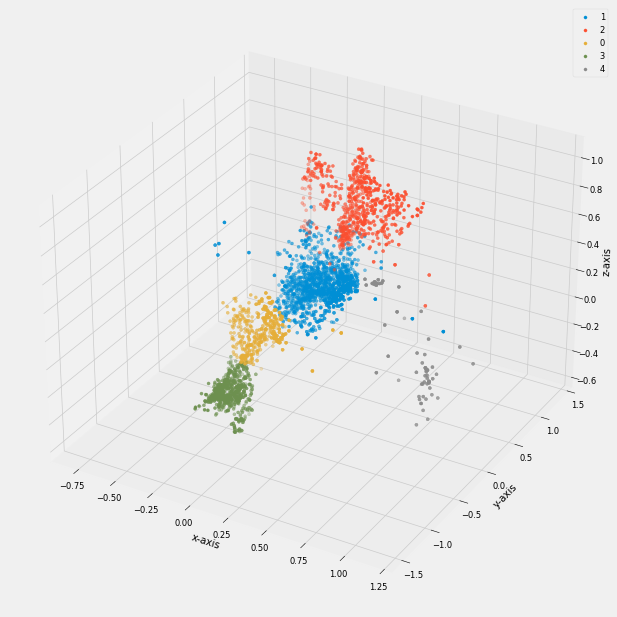

In [35]:
# number of clusters = 5
kmeans = KMeans(n_clusters=5, n_init=20, random_state=0)
subset = df_cluster[cluster_columns]
df_cluster["cluster"] = kmeans.fit_predict(subset)

# Plot the clusters
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection="3d")
for c in df_cluster["cluster"].unique():
    subset = df_cluster[df_cluster["cluster"] == c]
    ax.scatter(subset["acc_x"], subset["acc_y"], subset["acc_z"], label=c)
ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")
plt.legend()
plt.show()

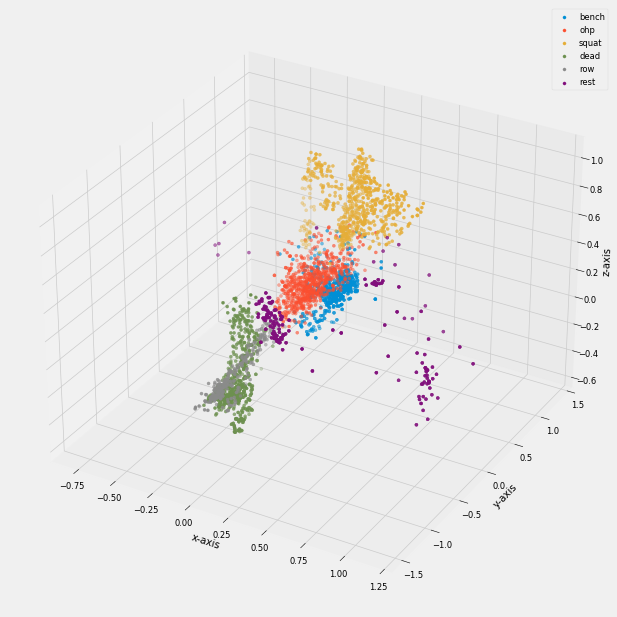

In [36]:
# Plot acc data to compare
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection="3d")
for l in df_cluster["label"].unique():
    subset = df_cluster[df_cluster["label"] == l]
    ax.scatter(subset["acc_x"], subset["acc_y"], subset["acc_z"], label=l)
ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")
plt.legend()
plt.show()

**Códigos orignais:** `../src/data/build_features.py`

**Arquivo salvo em:** `../data/interim/03_data_features.pkl"`

**Próxima etapa:** `05_train_model.ipynb`